## Comp Econ Homework 8

Daniel Csaba

UnivID: N12155064

## Exercise 1.

Define the open balls with radius one around the degenerate distributions by

\begin{equation}
B(\delta_s; 1):= \big\{\phi \in l_1^+(S) : \|\phi - \delta_s\| < 1\big\}.
\end{equation}



Take the open cover of $\mathcal{P}(S)$ given by the collection of sets $\{B(\delta_s;1)\}_{s \in S}$. Using the topological definition of compactness, 
$\mathcal{P}(S)$ being compact implies that every open cover of $\mathcal{P}(S)$ has a finite subcover.

The finite subcover of $\{B(\delta_s;1)\}_{s \in S}$ has to include all the balls centered around degenerate distributions---otherwise the degenerate distribution in the center of the not included ball would not be covered by this lacking collection. This is because $ \|\delta_q - \delta_s\| = 1$ for all $s\neq q$.

Hence, $S$ has to be finite.

## Exercise 2.

Suppose that there exist a stationary distribution $\psi^*$. Then, by definition 

\begin{equation}
\psi^*(y) = \sum_{x \in \mathbb{Z}} p(x,y) \psi^*(x) \qquad \forall y \in \mathbb{Z}.
\end{equation}


- For $y=0$ the above definition gives $\psi^*(y) =  0$ since $(0-1) \notin \mathbb{Z}$.

- Since $p(x,y) = \mathbb{1}\{x = y-1\}$ for all $x \in \mathbb{Z}$ one can show by induction that $\psi^*(n) =  0$ for all $n \in \mathbb{Z}$.

- However, this implies that

\begin{equation}
\| \psi^* \| = \sum_{x \in \mathbb{Z}} \big| \psi^*(x)\big| = \sum_{x \in \mathbb{Z}} 0 = 0 \neq 1.
\end{equation}


This is contradicting $\psi^* \in \mathcal{P}(\mathbb{Z})$.

## Exercise 3.

For the argument we can use the theorem provided during lecture. Namely, since the state space is finite, $p$ being both irreducible and aperiodic would imply that the stochastic kernel is globally stable.

#### Irreducibility
To get irreducibility one can show that there is a positive probability of reaching any state from any other state in at most two steps.

Clearly, if $x  \leq q$ or $\{q < x \leq Q$ and $y \leq x\}$ then $p(x,y)>0$ for any such states satisfying the conditions.

Take the only interesting case, when $q < x \leq Q$ and $y > x$. Then $p(x,y) = 0$, however, the following sequence could lead to $y$ from $x$ with positive probability in only two steps. Let $X_t = x$ with the above restrictions and $D_{t+1} > x-q$ which happens with strictly positive probability. Then $X_{t+1} < q$ and  a realization of $D_{t+2} = Q-y$ would lead to $X_{t+2} = y$ with positive probability. Specifically, in this scenario the probability would be given by

\begin{equation}
p(X_{t} = x, X_{t+2} = y) = p^2(x, y) = P(D = x-q) * P(D = Q-y).
\end{equation}

#### Aperiodicity
To see aperiodicity note that the  $p(x, x) > 0$ for every $x \in \big[0, Q\big]$. 

- If $x \leq q$ then we have that $P(D=Q-x)>0$.
- On the other hand, if $q < x$ we have that $P(D=0)>0$.

Either way we have that $p(x,x)>0$. Putting finiteness, irreducibility and aperiodicity together we get global stability.

## Exercise 4.

The task is to write a function which defines the stochastic kernel for each $(q, Q)$.

In [47]:
import numpy as np
import quantecon as qe

In [42]:
def inventory_kernel(q, Q):
    """Defines the stochastic kernel implicitly given in the inventory dynamics problem"""
    
    # Define probability of integer levels of demand
    p_demand = lambda d: .5 ** (d+1)
    # Define tail probability for demand P(D >= d)
    p_demand_tail = lambda d: 1 - .5*(1 - .5**d)/(1 - .5)
    
    # Define Markov operator
    P = np.zeros((Q+1,Q+1))
    for x in range(Q+1):
        for y in range(Q+1):
            if x <= q and y != 0:               # topping up inventory, anything possible depending on demand
                P[x,y] = p_demand(Q-y)
            elif x <= q and y == 0:             # pool tail probabilities for zero inventory next period (D>=Q)
                P[x,y] = p_demand_tail(Q)
            elif x > q and y > x:               # not topping up inventory, can't have more in next period
                P[x,y] = 0
            elif x > q and y != 0:              # can have less in next period (D<x)
                P[x,y] = p_demand(x-y)
            else:
                P[x,y] = p_demand_tail(x)       # pool tail probabilities for zero inventory next period (D>=x)
    return P

Now, using this function we can define the Markov operator for the case $q=2$ and $Q=5$.

In [127]:
P = inventory_kernel(2, 5)
print(P)

[[ 0.03125  0.03125  0.0625   0.125    0.25     0.5    ]
 [ 0.03125  0.03125  0.0625   0.125    0.25     0.5    ]
 [ 0.03125  0.03125  0.0625   0.125    0.25     0.5    ]
 [ 0.125    0.125    0.25     0.5      0.       0.     ]
 [ 0.0625   0.0625   0.125    0.25     0.5      0.     ]
 [ 0.03125  0.03125  0.0625   0.125    0.25     0.5    ]]


Invoking the `MarkovChain` class from the `quantecon` package we can quickly get the stationary distribution.

In [56]:
mc = qe.MarkovChain(P)
print('The stationary distribution is: {}'.format(mc.stationary_distributions))

The stationary distribution is: [[ 0.0625  0.0625  0.125   0.25    0.25    0.25  ]]


## Exercise 5.

As the stochastic kernel associated with the inventory dynamics problem is globally stable for any initial probability distribution applying the Markov operator successively will converge to the unique stationary distribution.

The following function is going to implement these ideas.

In [72]:
def Markov_iteration(P, maxiter, tol):
    """Apply globally stable Markov operator successively to find the unique stationary distribution."""
    
    p = np.ones(P.shape[0])/P.shape[0] # set the initial prob. dist. to uniform
    current_iter = 0
    dist = 2*tol
    
    while dist > tol and current_iter < maxiter:
        p_new = p @ P
        dist = sum(abs(p_new - p))
        p = p_new
        current_iter += 1
    return p, current_iter

In [71]:
maxiter = 10000
tol = 0.000001

mark_iter = Markov_iteration(P, maxiter, tol)

print('The stationary distribution is: {}'.format(mark_iter[0]))
print('The nubmer of iterations to achieve convergence: {}'.format(mark_iter[1]))

The stationary distribution is: [ 0.06249997  0.06249997  0.12499994  0.24999988  0.2499999   0.25000034]
The nubmer of iterations to achieve convergence: 13


As we can see convergence occurs pretty fast with quite high precision.

## Exercise 6.

Now, plot the different stationary distributions for $Q=20$ and $q=2,5,10,15$.

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('bmh')

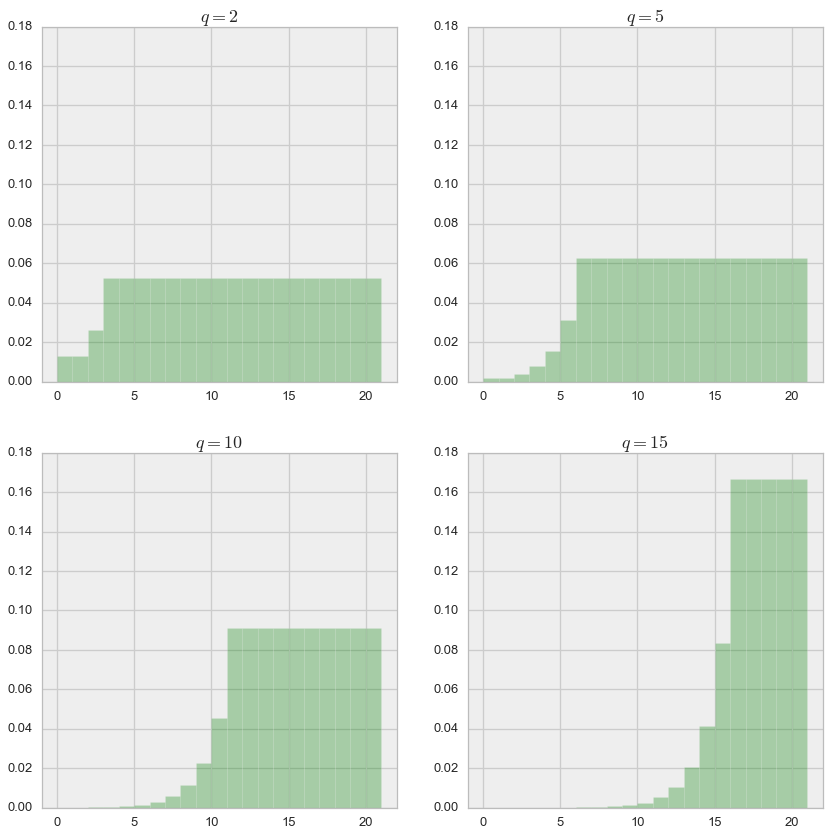

In [125]:
Q = 20
q_list = [2, 5, 10, 15]

x = np.arange(Q+1)
width = 1     

f, axes = plt.subplots(2, 2, figsize=(14, 14))

for ax, q in zip(axes.flat, q_list):
    P = inventory_kernel(q, Q)
    stat_dist = qe.MarkovChain(P).stationary_distributions.reshape(P.shape[0],)
    ax.bar(x, stat_dist, width, color="g", alpha=.3)
    ax.set_title("$q ={}$".format(q), fontsize=18)
    ax.set_ylim([0,.18])
    ax.set_xlim([-1,22])
plt.show()

We see on the graphs that as we increase the threshold for refilling the inventory the stationary distribution centers its mass on the high inventory states. This is due to the fact that the distribution of demand levels does not change and hence the probability of holding high inventory is increasing with the threshold for refilling.